In [4]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco


In [5]:
# Configs

DATASET_FILE  = '../data/preprocess/data_simple.csv'
TARGET_NAME = 'health'
TEST_SIZE = 0.2
TIMEOUT = 30 * 60 # value in seconds, multiply on 60 for minutes
N_FOLDS = 10
RANDOM_STATE = 42
N_THREADS = os.cpu_count() - 1 # left one core for system

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [6]:
data = pd.read_csv(DATASET_FILE)

In [7]:
display(data.info())
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642961 entries, 0 to 642960
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tree_id           642961 non-null  int64  
 1   block_id          642961 non-null  int64  
 2   created_at        642961 non-null  object 
 3   tree_dbh          642961 non-null  int64  
 4   stump_diam        642961 non-null  int64  
 5   curb_loc          642961 non-null  object 
 6   status            642961 non-null  object 
 7   health            642961 non-null  object 
 8   spc_latin         642961 non-null  object 
 9   spc_common        642961 non-null  object 
 10  steward           642961 non-null  object 
 11  guards            642961 non-null  object 
 12  sidewalk          642961 non-null  object 
 13  user_type         642961 non-null  object 
 14  problems          642961 non-null  object 
 15  root_stone        642961 non-null  object 
 16  root_grate        64

None

tree_id  block_id  created_at  tree_dbh  stump_diam curb_loc status  \
194440   388026    310882  2015-10-27        10           0   OnCurb  Alive   
469560   711210    203355  2016-09-13        23           0   OnCurb  Alive   
314342   547021    401553  2016-02-15         5           0   OnCurb  Alive   
219986   403917    508632  2015-10-30         3           0   OnCurb  Alive   
465136   705954    231522  2016-09-09        12           0   OnCurb  Alive   
212281   412495    306492  2015-11-01        18           0   OnCurb  Alive   
298396   524710    343077  2015-12-17         3           0   OnCurb  Alive   
28090    233787    413548  2015-09-17        10           0   OnCurb  Alive   
479815   702254    211025  2016-09-07        16           0   OnCurb  Alive   
177688   398198    109511  2015-10-29         3           0   OnCurb  Alive   

       health                           spc_latin        spc_common  ...  \
194440   Good                    Acer platanoides      Norway maple  ...   
469560   Good               Platanus x acerifolia  London planetree  ...   
314342   Good                         Acer rubrum         red maple  ...   
219986   Good                                Acer             maple  ...   
465136   Good              Fraxinus pennsylvanica         green ash  ...   
212281   Fair                    Acer platanoides      Norway maple  ...   
298396   Good                       Lagerstroemia      crepe myrtle  ...   
28090    Good                    Pyrus calleryana      Callery pear  ...   
479815   Good                    Pyrus calleryana      Callery pear  ...   
177688   Good  Gleditsia triacanthos var. inermis       honeylocust  ...   

        boro_ct     state   latitude  longitude          x_sp         y_sp  \
194440  4083700  New York  40.742679 -73.816557  1.035083e+06  209907.9264   
469560  3015000  New York  40.617421 -74.008914  9.817752e+05  164219.7415   
314342  5004000  New York  40.618755 -74.075302  9.633446e+05  164714.6792   
219986  2009200  New York  40.833711 -73.849117  1.026003e+06  243056.7410   
465136  3094401  New York  40.641442 -73.925312  1.004978e+06  172979.9576   
212281  4122300  New York  40.732121 -73.800353  1.039582e+06  206071.0659   
298396  4045900  New York  40.740237 -73.870467  1.020145e+06  208991.4997   
28090   5017008  New York  40.559732 -74.176483  9.352117e+05  143251.2503   
479815  3089400  New York  40.662950 -73.915926  1.007575e+06  180818.3090   
177688  1023000  New York  40.818660 -73.941717  1.000382e+06  237542.4016   

       council_district census_tract        bin           bbl  
194440             20.0        837.0  4141150.0  4.064310e+09  
469560             43.0        150.0  3162550.0  3.062680e+09  
314342             49.0         40.0  5042381.0  5.028390e+09  
219986             18.0         92.0  2026952.0  2.038230e+09  
465136             45.0      94401.0  3321116.0  3.079300e+09  
212281             24.0       1223.0  4149988.0  4.069400e+09  
298396             25.0        459.0  4046133.0  4.018670e+09  
28090              51.0      17008.0  5150095.0  5.056520e+09  
479815             41.0        894.0  3320005.0  3.035680e+09  
177688              9.0        230.0  1060413.0  1.020260e+09  

[10 rows x 45 columns]

In [8]:
train_data, test_data = train_test_split(
    data,
    test_size=TEST_SIZE,
    stratify=data[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (514368, 45), test_data = (128593, 45)


tree_id  block_id  created_at  tree_dbh  stump_diam curb_loc status  \
381357   561883    316076  2016-05-19         2           0   OnCurb  Alive   
326440   562252    206385  2016-05-19        35           0   OnCurb  Alive   
517496    53356    107094  2015-07-07         7           0   OnCurb  Alive   
40389    250561    201523  2015-09-23        43           0   OnCurb  Alive   
575391   126754    414076  2015-08-07        13           0   OnCurb  Alive   

       health                           spc_latin        spc_common  ...  \
381357   Good                         Amelanchier      serviceberry  ...   
326440   Good               Platanus x acerifolia  London planetree  ...   
517496   Good  Gleditsia triacanthos var. inermis       honeylocust  ...   
40389    Fair               Platanus x acerifolia  London planetree  ...   
575391   Good                       Quercus rubra  northern red oak  ...   

        boro_ct     state   latitude  longitude          x_sp         y_sp  \
381357  4099100  New York  40.795431 -73.802248  1.039004e+06  229135.6602   
326440  3026000  New York  40.617249 -73.990104  9.869973e+05  164156.9877   
517496  1010602  New York  40.760436 -73.960214  9.952719e+05  216326.7121   
40389   3115200  New York  40.671988 -73.890197  1.014709e+06  184118.7050   
575391  5013203  New York  40.546474 -74.147254  9.433253e+05  138406.2226   

       council_district census_tract        bin           bbl  
381357             19.0        991.0  4103514.0  4.045520e+09  
326440             47.0        260.0  3134376.0  3.055610e+09  
517496              5.0      10602.0  1045283.0  1.014560e+09  
40389              37.0       1152.0  3089085.0  3.040090e+09  
575391             51.0      13203.0  5065760.0  5.051480e+09  

[5 rows x 45 columns]

In [9]:
# specify task type
task = Task( 'multiclass')

# specify feature roles
roles = {
    'target': TARGET_NAME,  # required
    'drop': ['tree_id']  # remove tree's id
}


In [10]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [11]:
%%time
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[14:39:08] Stdout logging level is INFO.
[14:39:08] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[14:39:08] Task: multiclass

[14:39:08] Start automl preset with listed constraints:
[14:39:08] - time: 1800.00 seconds
[14:39:08] - CPU: 15 cores
[14:39:08] - memory: 16 GB

[14:39:08] Train data shape: (514368, 45)

[14:39:14] Layer 1 train process start. Time left 1794.34 secs
[14:39:29] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:41:08] Time limit exceeded after calculating fold 2

[14:41:08] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5195541077202422
[14:41:08] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:41:08] Time left 1680.19 secs

[14:41:48] Selector_LightGBM fitting and predicting completed
[14:42:03] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[14:44:53] Time limit exceeded after calculating fold 1

[14:44:53] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.45579938727650315


In [12]:
%%time

test_predictions = automl_rd.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[0.78624463, 0.20479058, 0.00896487],
       [0.95712125, 0.04166742, 0.00121142],
       [0.9904628 , 0.00834214, 0.00119509],
       ...,
       [0.56924814, 0.33199728, 0.09875463],
       [0.8351885 , 0.139685  , 0.02512652],
       [0.9577482 , 0.03962342, 0.00262839]], dtype=float32)
Shape = (128593, 3)
CPU times: user 3min 27s, sys: 170 ms, total: 3min 28s
Wall time: 15.5 s


In [13]:
# class mapping
mapping = automl_rd.model.reader.class_mapping
def map_class(x):
    return mapping[x]

mapped = np.vectorize(map_class)
mapped(train_data['health'].values)

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
oof_f1_score = f1_score(mapped(train_data[TARGET_NAME].values),
                        np.argmax(out_of_fold_predictions.data, axis=1),
                        average="micro" # because of disbalance
                        )
holdout_f1_score = f1_score(mapped(test_data[TARGET_NAME].values),
                            np.argmax(test_predictions.data, axis=1),
                            average="micro")

print(f'OOF f1 score: {oof_f1_score}')
print(f'HOLDOUT f1 score: {holdout_f1_score}')


OOF f1 score: 0.8209919746173946
HOLDOUT f1 score: 0.8308539345065439


In [15]:
print(automl_rd.model.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.58074 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.41926 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


CPU times: user 41.8 ms, sys: 23.9 ms, total: 65.7 ms
Wall time: 40 ms


<Axes: xlabel='Feature'>

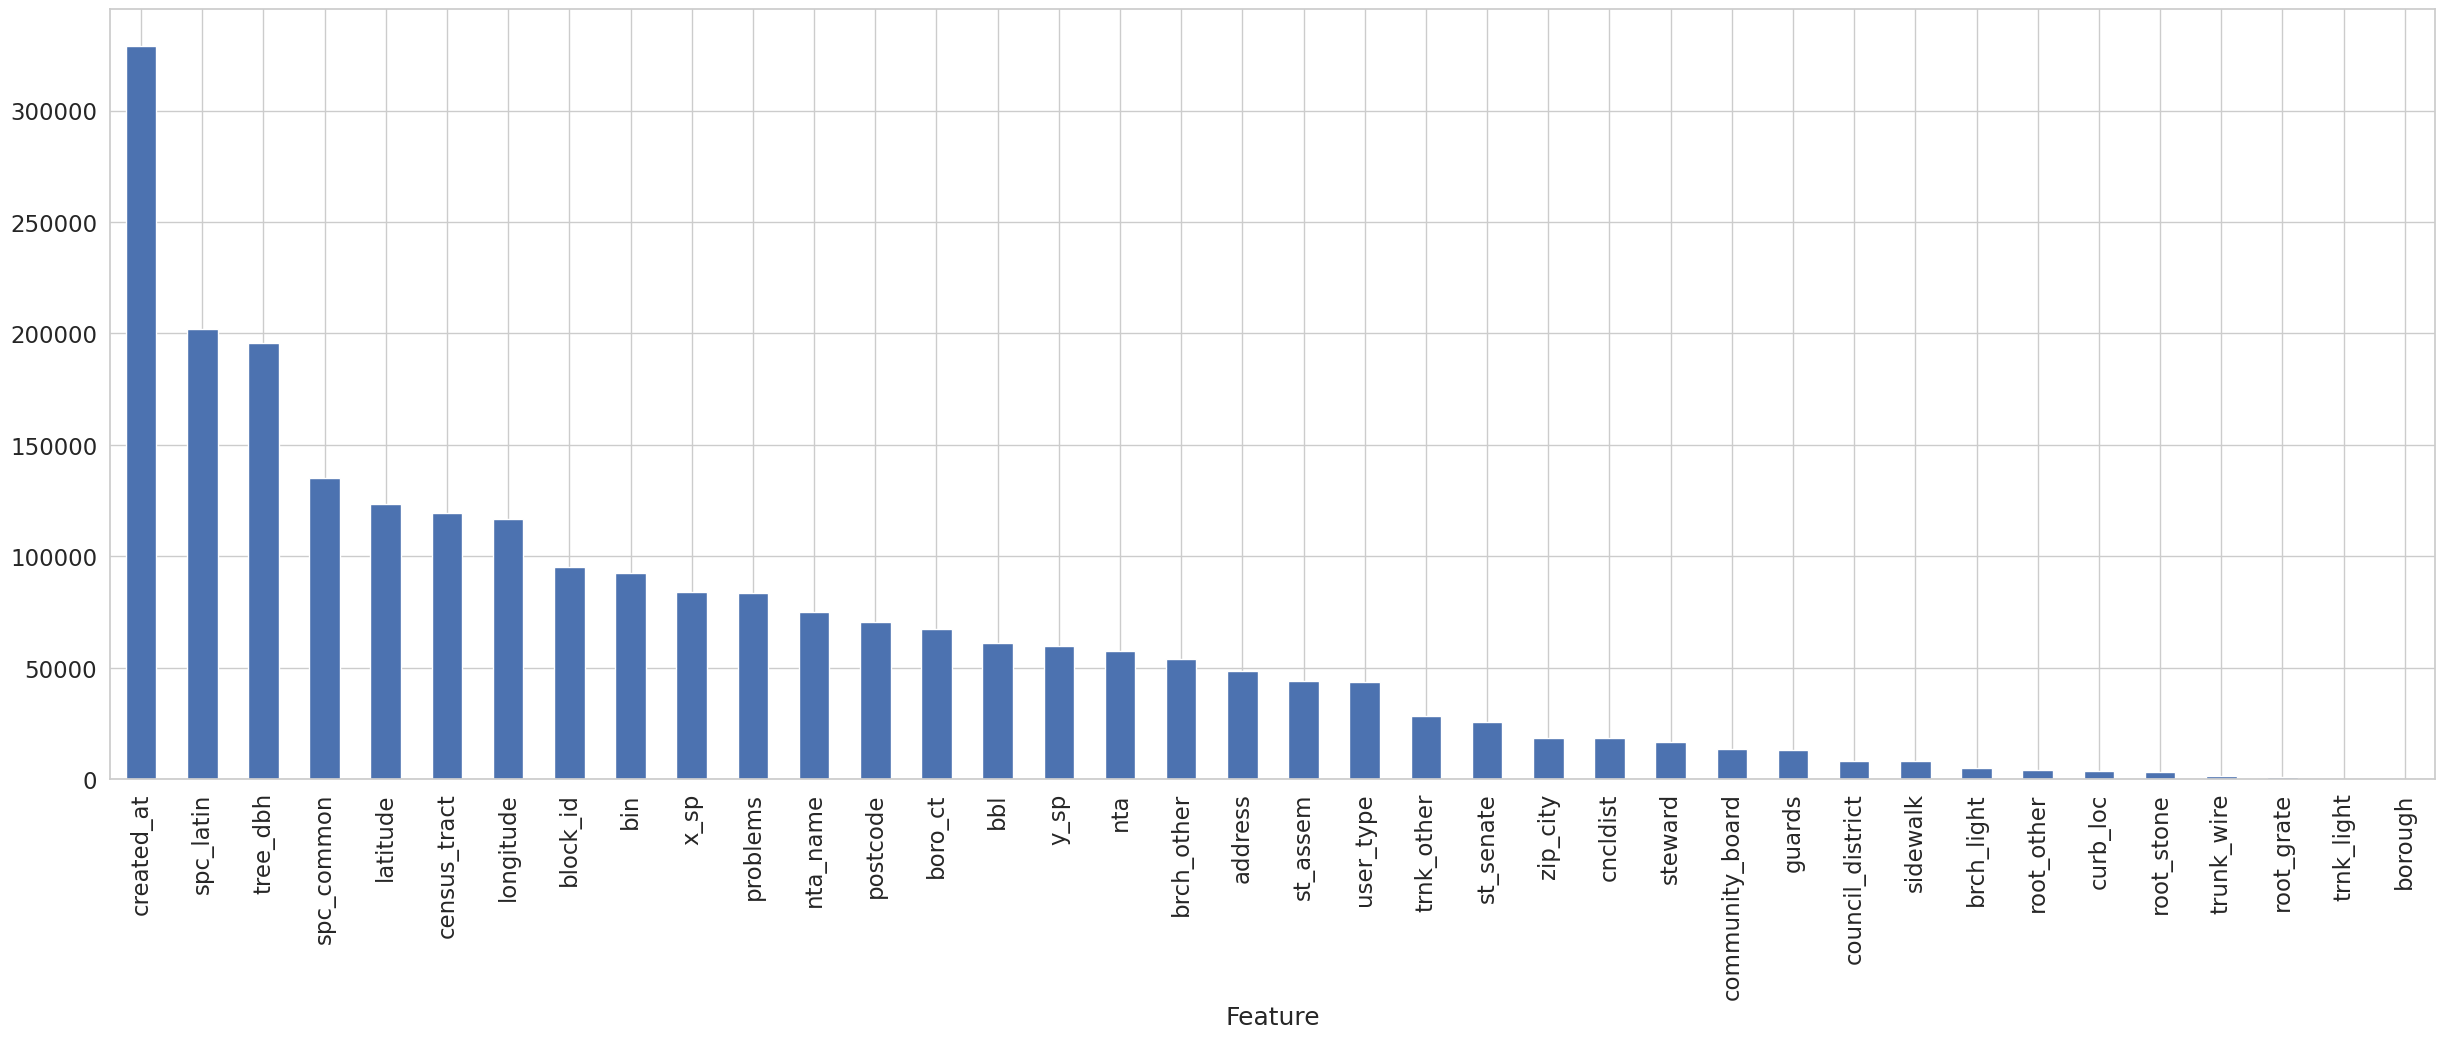

In [16]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [17]:
%%time

# Accurate feature importances calculation with detailed info (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', test_data, silent = True)

CPU times: user 2h 15min 32s, sys: 881 ms, total: 2h 15min 33s
Wall time: 10min 4s


<Axes: xlabel='Feature'>

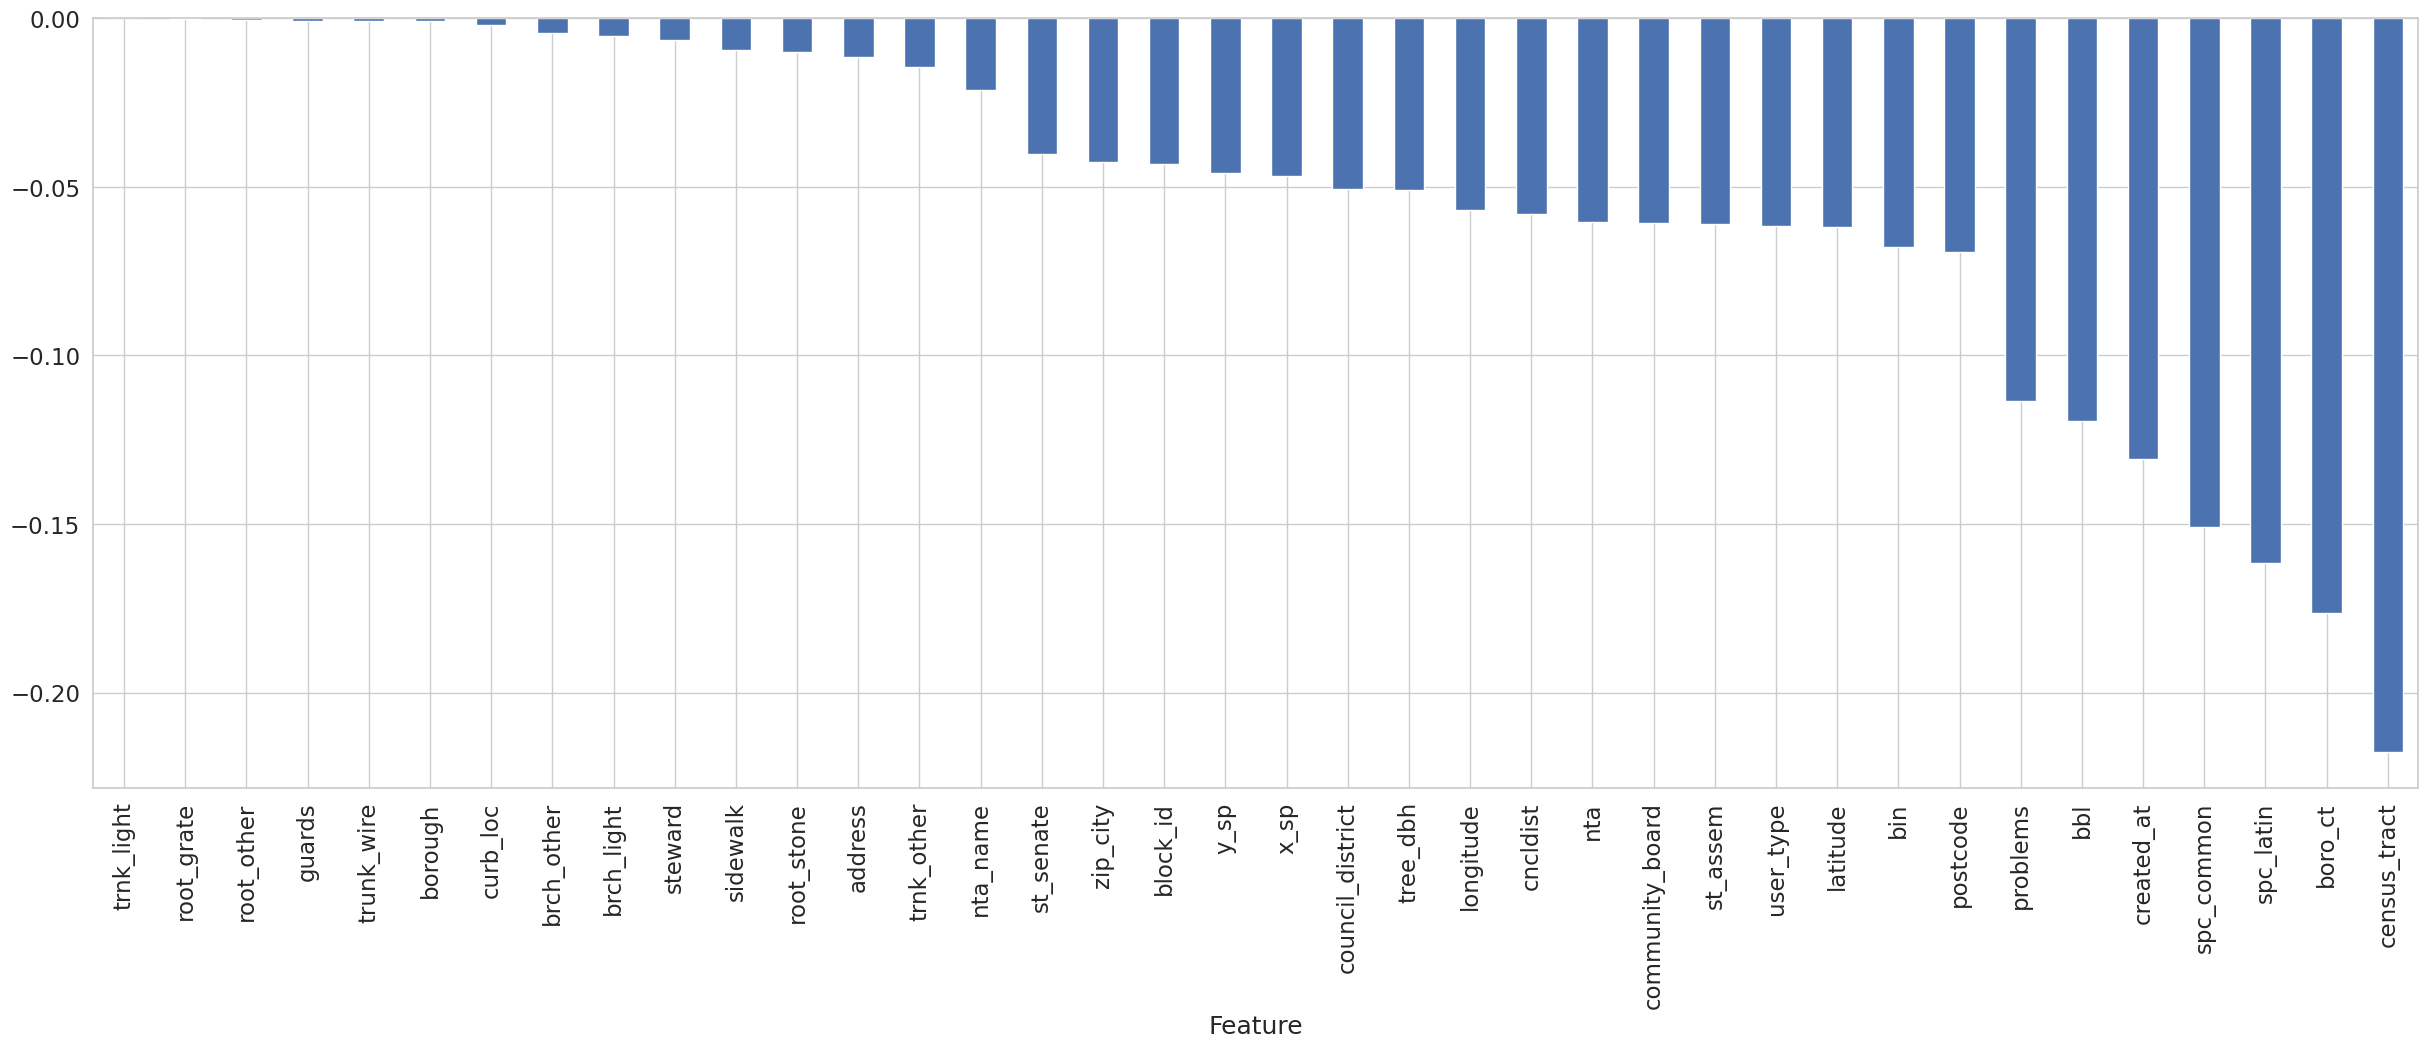

In [18]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)